# relu梯度爆炸

Layer 1 weight: 0.7645, bias: 0.8300
Layer 2 weight: -0.2343, bias: 0.9186
Layer 3 weight: -0.2191, bias: 0.2018
Layer 4 weight: -0.4869, bias: 0.5873
Layer 5 weight: 0.8815, bias: -0.7336
Layer 6 weight: 0.8692, bias: 0.1872
Layer 7 weight: 0.7388, bias: 0.1354
Layer 8 weight: 0.4822, bias: -0.1412
Layer 9 weight: 0.7709, bias: 0.1478
Layer 10 weight: -0.4668, bias: 0.2549
Layer 11 weight: -0.4607, bias: -0.1173
Layer 12 weight: -0.4062, bias: 0.6634
Layer 13 weight: -0.7894, bias: -0.4610
Layer 14 weight: -0.2824, bias: -0.6013
Layer 15 weight: 0.0944, bias: -0.9877
Layer 16 weight: 0.9031, bias: -0.8495
Layer 17 weight: 0.7720, bias: 0.1664
Layer 18 weight: -0.3247, bias: 0.6179
Layer 19 weight: 0.1559, bias: 0.8080
Layer 20 weight: 0.1093, bias: -0.3154
Output value: 4255.4160
Layer 1 gradient norm: 2602.2952
Layer 2 gradient norm: 1658.9581
Layer 3 gradient norm: 1130.6781
Layer 4 gradient norm: 715.8470
Layer 5 gradient norm: 468.4397
Layer 6 gradient norm: 311.1282
Layer 7 gradi

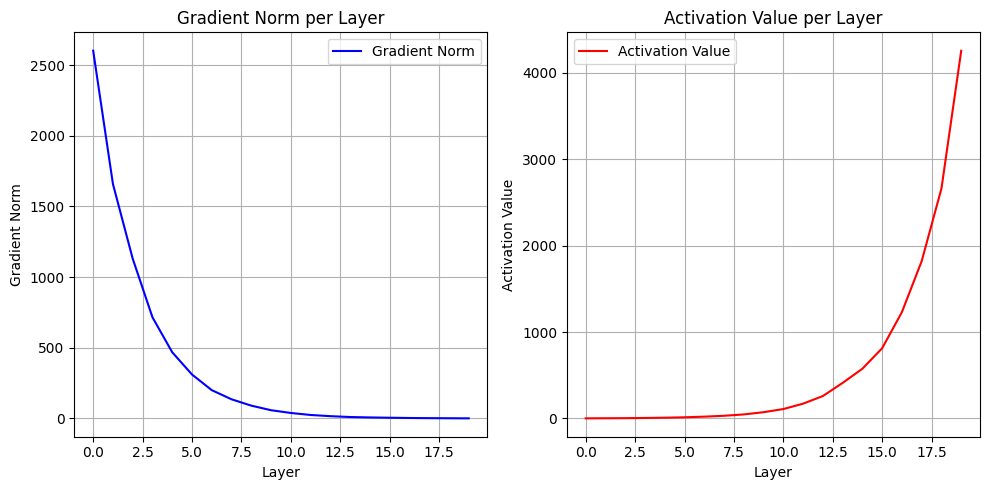


Maximum gradient norm: 2602.2952
Minimum gradient norm: 1.0000
Gradient norm ratio (max/min): 2602.2952


In [23]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 设置随机种子以保证结果可复现
torch.manual_seed(42)

# 创建一个简单的深度网络，只使用ReLU激活函数
class DeepReLUNetwork(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(1, 1) for _ in range(num_layers)
        ])
        self.relu = nn.ReLU()
        self.gradients = []  # 存储中间梯度
        
        # 使用较大的权重初始化
        for layer in self.layers:
            nn.init.normal_(layer.weight, mean=1.5, std=0.1)
            nn.init.zeros_(layer.bias)
        for i, layer in enumerate(model.layers):
            print(f"Layer {i+1} weight: {layer.weight.item():.4f}, bias: {layer.bias.item():.4f}")
        print("========")
    
    def forward(self, x):
        intermediates = []  # 存储中间结果
        for layer in self.layers:
            x = layer(x)
            intermediates.append(x)  # 保存每一层的输出
            x = self.relu(x)
        
        # 为每个中间结果注册hook
        for i, intermediate in enumerate(intermediates):
            intermediate.register_hook(lambda grad, idx=i: self.gradients.insert(0, grad.item()))  # 注意使用insert(0,)
        return x

# 创建网络实例和训练数据
num_layers = 20  # 使用20层使梯度爆炸更明显
model = DeepReLUNetwork(num_layers)
x = torch.ones(1, 1, requires_grad=True)

# 记录每层的梯度
gradients = []
activations = []

# 前向传播，记录每层激活值
def hook_fn(module, input, output):
    activations.append(output.detach().numpy())

for layer in model.layers:
    layer.register_forward_hook(hook_fn)

# 前向传播
output = model(x)
print(f"Output value: {output.item():.4f}")

# 反向传播
output.backward()

for i, grad in enumerate(model.gradients):
    print(f"Layer {i+1} gradient norm: {grad:.4f}")
    gradients.append(grad)

# 可视化梯度变化
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(gradients, 'b-', label='Gradient Norm')
plt.title('Gradient Norm per Layer')
plt.xlabel('Layer')
plt.ylabel('Gradient Norm')
plt.legend()
plt.grid(True)

# 可视化激活值变化
plt.subplot(1, 2, 2)
activations = [a.flatten()[0] for a in activations]
plt.plot(activations, 'r-', label='Activation Value')
plt.title('Activation Value per Layer')
plt.xlabel('Layer')
plt.ylabel('Activation Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 打印最大和最小梯度，展示梯度范围
print(f"\nMaximum gradient norm: {max(gradients):.4f}")
print(f"Minimum gradient norm: {min(gradients):.4f}")
print(f"Gradient norm ratio (max/min): {max(gradients)/min(gradients):.4f}")

# 初始化合理改造

Output value: 0.1448
Layer 1 gradient norm: 0.0000
Layer 2 gradient norm: 0.0000
Layer 3 gradient norm: 0.0000
Layer 4 gradient norm: 0.0000
Layer 5 gradient norm: 0.0000
Layer 6 gradient norm: 0.0000
Layer 7 gradient norm: 0.0000
Layer 8 gradient norm: 0.0000
Layer 9 gradient norm: 0.0001
Layer 10 gradient norm: 0.0002
Layer 11 gradient norm: 0.0008
Layer 12 gradient norm: 0.0021
Layer 13 gradient norm: 0.0043
Layer 14 gradient norm: 0.0132
Layer 15 gradient norm: 0.0302
Layer 16 gradient norm: 0.0902
Layer 17 gradient norm: 0.2205
Layer 18 gradient norm: 0.4800
Layer 19 gradient norm: 1.0000


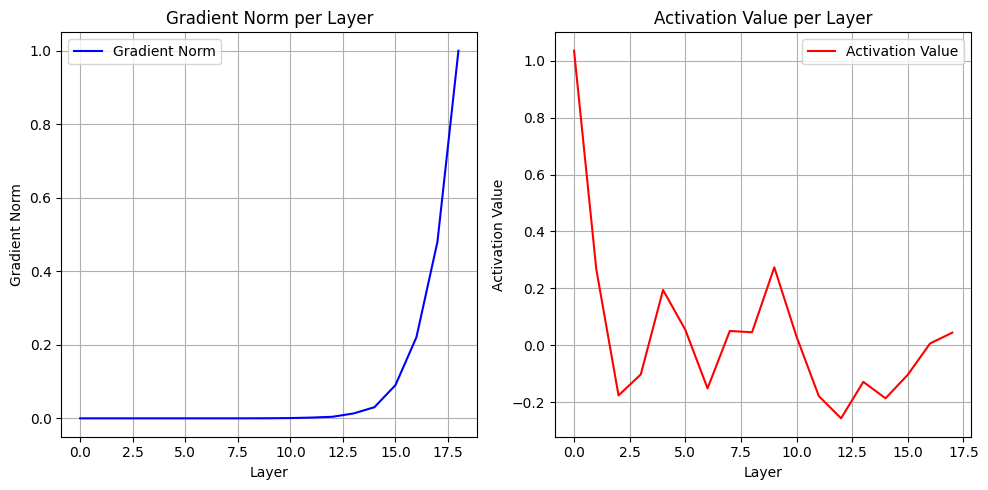


Maximum gradient norm: 1.0000
Minimum gradient norm: 0.0000
Gradient norm ratio (max/min): 81621739.5590


In [31]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 设置随机种子以保证结果可复现
torch.manual_seed(42)

# 创建一个简单的深度网络，只使用ReLU激活函数
class DeepReLUNetwork(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        hidden_dim = 16
        
        # 1维 -> 16维 -> ... -> 16维 -> 1维
        self.input_layer = nn.Linear(1, hidden_dim)
        self.layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers-2)
        ])
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.relu = nn.LeakyReLU(0.01)
        self.gradients = []
        
        # 初始化所有层
        for layer in [self.input_layer] + list(self.layers) + [self.output_layer]:
            nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
            nn.init.constant_(layer.bias, 0.01)
    
    def forward(self, x):
        # 输入层
        x = self.relu(self.input_layer(x))
        
        intermediates = []
        # 隐藏层
        for layer in self.layers:
            x = layer(x)
            intermediates.append(x)
            x = self.relu(x)
        
        # 输出层
        x = self.output_layer(x)
        intermediates.append(x)
        
        # 注册梯度hook
        for i, intermediate in enumerate(intermediates):
            intermediate.register_hook(lambda grad, idx=i: self.gradients.insert(0, grad.norm().item()))
        
        return x

# 创建网络实例和训练数据
num_layers = 20  # 使用20层使梯度爆炸更明显
model = DeepReLUNetwork(num_layers)
x = torch.ones(1, 1, requires_grad=True)

# 记录每层的梯度
gradients = []
activations = []

# 前向传播，记录每层激活值
def hook_fn(module, input, output):
    activations.append(output.detach().numpy())

for layer in model.layers:
    layer.register_forward_hook(hook_fn)

# 前向传播
output = model(x)
print(f"Output value: {output.item():.4f}")

# 反向传播
output.backward()

for i, grad in enumerate(model.gradients):
    print(f"Layer {i+1} gradient norm: {grad:.4f}")
    gradients.append(grad)

# 可视化梯度变化
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(gradients, 'b-', label='Gradient Norm')
plt.title('Gradient Norm per Layer')
plt.xlabel('Layer')
plt.ylabel('Gradient Norm')
plt.legend()
plt.grid(True)

# 可视化激活值变化
plt.subplot(1, 2, 2)
activations = [a.flatten()[0] for a in activations]
plt.plot(activations, 'r-', label='Activation Value')
plt.title('Activation Value per Layer')
plt.xlabel('Layer')
plt.ylabel('Activation Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 打印最大和最小梯度，展示梯度范围
print(f"\nMaximum gradient norm: {max(gradients):.4f}")
print(f"Minimum gradient norm: {min(gradients):.4f}")
print(f"Gradient norm ratio (max/min): {max(gradients)/min(gradients):.4f}")